In [386]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [387]:
# Temperature Profile 
rawD = pd.read_excel('parameters.xlsx',sheet_name='data')
Volt0 = rawD['V'].values
tp = rawD['t'].values
Tmax = rawD['exp Tmax'].values
Tvag = rawD['exp Tavg'].values
kh = rawD['kh'].values
ht = rawD['ht'].values

In [388]:
# Feed composition
T0 = 760 # inlet temperature [K]
P0 = ct.one_atm # constant pressure [Pa]
C0 = 'CH4(1):1.0' # inlet composition
VF = 10/1e6/60 # inelt volumetric flow rate [m3/s]

In [389]:
# Reactor Configuration
ID = 2.54/2/100 # inner diameter [m]
A = 3.141592 * ID**2 / 4 # cross secional area [m2]
V0 = VF/A # superficial velocity [m/s]
L = 0.02 # carbon paper length [m]
L/V0

15.201221210400002

In [390]:
# Time
dt = 1e-4
total_time = 1e-1
t = np.arange(0,total_time+dt,dt)

In [391]:
# Power Function
def power(V0,tp):
    wv = np.zeros(len(t))
    a = 0.003
    b = tp
    c = 1e-5
    d = 1.1

    cycle = d # 1 cycle time (s)
    num_cycles = int(np.floor(total_time / cycle)) # number of complete cycles
    res_time = total_time % cycle

    for i in range(len(t)):
        current_time_in_cycle = t[i] % cycle  # 현재 시간을 한 사이클 내의 시간으로 변환

        if current_time_in_cycle < 0.01:
            wv[i] = c
        elif (0.01 <= current_time_in_cycle) & (current_time_in_cycle < (0.01 + a/2)):
            wv[i] = c + 2/a**2 * (current_time_in_cycle - 0.01)**2
        elif (0.01 + a/2 <= current_time_in_cycle) & (current_time_in_cycle < (0.01 + a)):
            wv[i] = c + -2/a**2 * (current_time_in_cycle - 0.01 - a)**2 + 1
        elif ((0.01 + a) <= current_time_in_cycle) & (current_time_in_cycle < (0.01 + b - a)):
            wv[i] = c + 1
        elif ((0.01 + b - a) <= current_time_in_cycle) & (current_time_in_cycle < (0.01 + b - a/2)):
            wv[i] = c + -2/a**2 * (current_time_in_cycle - 0.01 - b + a)**2 + 1
        elif ((0.01 + b - a/2) <= current_time_in_cycle) & (current_time_in_cycle < (0.01 + b)):
            wv[i] = c + 2/a**2 * (current_time_in_cycle - 0.01 - b)**2
        else:
            wv[i] = c

    V = V0 * wv
    return V**2 / 4.418081

In [392]:
# Heat Balance Function
def heat_balance_exp(V0,tp,kh,ht):
    T0 = 730
    T = np.zeros(len(t))+T0
    P = power(V0,tp)
    Q = np.zeros(len(t))

    for i in range(len(Q)-1):
        Cp = kh*0.010783 #J/K       
        dQ = (T[i]-T0)
        if dQ <= 0:
            dQ = 1e-6
        Q = P[i]*(dt) - ht*dQ**(1)*(dt)
        T[i+1] = Q/Cp + T[i]

    return T

In [393]:
T_exp = list(range(len(Volt0)))
T_max = list(range(len(Volt0)))
for i in range(len(Volt0)):
    T_exp[i]=heat_balance_exp(Volt0[i],tp[i],kh[i],ht[i])
    T_max[i] = float(max(T_exp[i]))

In [399]:
print(T_exp[0])
print(len(T_exp))

[730.         730.         730.         ... 873.89956852 873.82014327
 873.74076185]
16


In [394]:
# Reaction Mechanism
mechanism = 'MechV1-19_optimal_gas.yaml'

In [395]:
# import the gas model and set the initial conditions
gas = ct.Solution(mechanism)
gas.TPX = 730, ct.one_atm, 'CH4(1):1'

In [436]:
temperature = np.zeros(len(t))
pressure = np.zeros(len(t))
mole_fractions = np.zeros((len(t), len(gas.species_names)))

# 시뮬레이션 루프 (진행도 표시)
for i in tqdm(range(len(t))):
    # 시뮬레이션 전 각 단계에서 반응기의 온도와 압력, 조성을 수동으로 설정
    gas.TPX = T_exp[15][i], gas.P, mole_fractions[i-1,:]  # 온도 프로파일을 강제로 적용
    
    # 매번 새로운 reactor를 생성하여 갱신된 상태 반영
    reactor = ct.IdealGasConstPressureReactor(gas, energy='off')  # 비등온 반응기 설정
    
    # 새로운 반응기 네트워크를 생성
    sim = ct.ReactorNet([reactor])
    
    # 시뮬레이션 진행
    sim.advance(dt)  # 시간 간격만큼 진행
    
    # 결과 저장
    temperature[i] = reactor.T  # 현재 온도
    pressure[i] = reactor.thermo.P  # 현재 압력
    mole_fractions[i, :] = reactor.thermo.X  # 현재 몰분율

  0%|          | 0/1001 [00:00<?, ?it/s]


CanteraError: 
*******************************************************************************
CanteraError thrown by Phase::setDensity:
density must be positive. density = -nan
*******************************************************************************


C:\Users\USER\AppData\Local\Temp\ipykernel_3828\3258448849.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0)


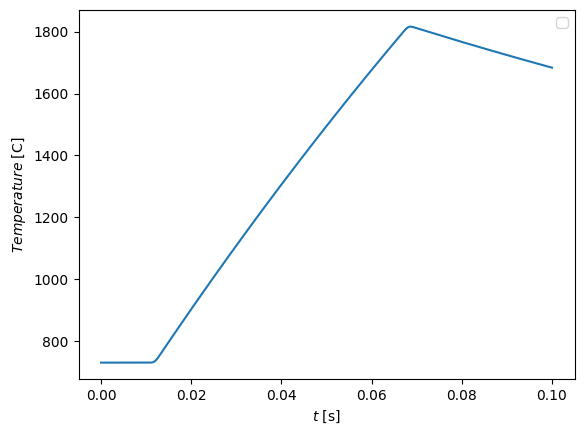

In [402]:
plt.figure()
plt.plot(t, temperature)
plt.xlabel('$t$ [s]')
plt.ylabel('$Temperature$ [C]')
plt.legend(loc=0)


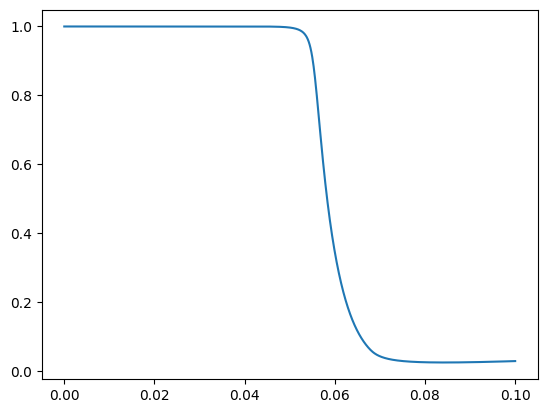

In [434]:
CH4 = [float(i) for i in mole_fractions[:,0]]
plt.plot(t,CH4)

In [417]:
print(mole_fractions[0,:])

[1.00000000e+000 3.29173092e-020 1.59820985e-020 5.81823006e-053
 4.96141925e-039 5.19755526e-169 0.00000000e+000 9.52969140e-022
 7.19004857e-056 1.86338349e-030 1.86991110e-060 2.41150586e-026
 1.39073749e-037 2.06771834e-190 0.00000000e+000 0.00000000e+000
 2.88903278e-170 0.00000000e+000 3.41130333e-075 9.98078387e-061
 7.96651550e-196 1.33680936e-098 3.59349590e-061 3.65610028e-062
 4.80073832e-112 1.39203078e-095 2.09615621e-243 2.33225130e-085
 3.97940948e-091 2.34420000e-075 8.19809545e-078 1.09604453e-075
 9.84757160e-086 2.52906093e-115 4.57560036e-115 4.59702005e-090
 5.39120178e-099 3.39458139e-135 7.35878433e-079 1.58467473e-115
 2.78669219e-099 2.46207454e-085 6.77964087e-115 9.29970258e-141
 7.81247587e-100 2.72540533e-099 6.53842210e-157 8.73060155e-136
 2.39786512e-099 2.94822498e-095 5.03347791e-112 9.90829196e-109
 1.61587118e-148 2.72507590e-152 8.77773898e-108 3.05775790e-112
 7.65410056e-114 5.75714971e-119 1.35381891e-102 8.88256690e-123
 5.30687052e-115 1.716242

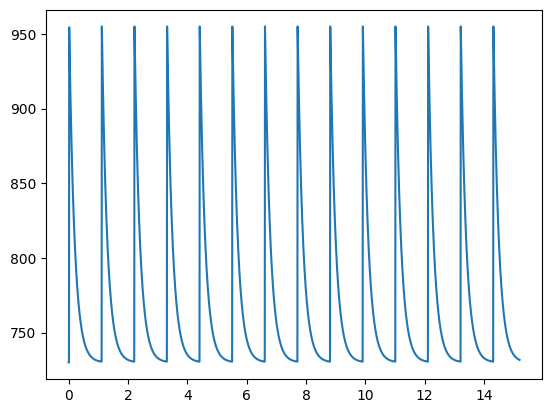

In [249]:
plt.plot(t, T_exp[0])

100%|██████████| 100/100 [00:00<00:00, 139.15it/s]


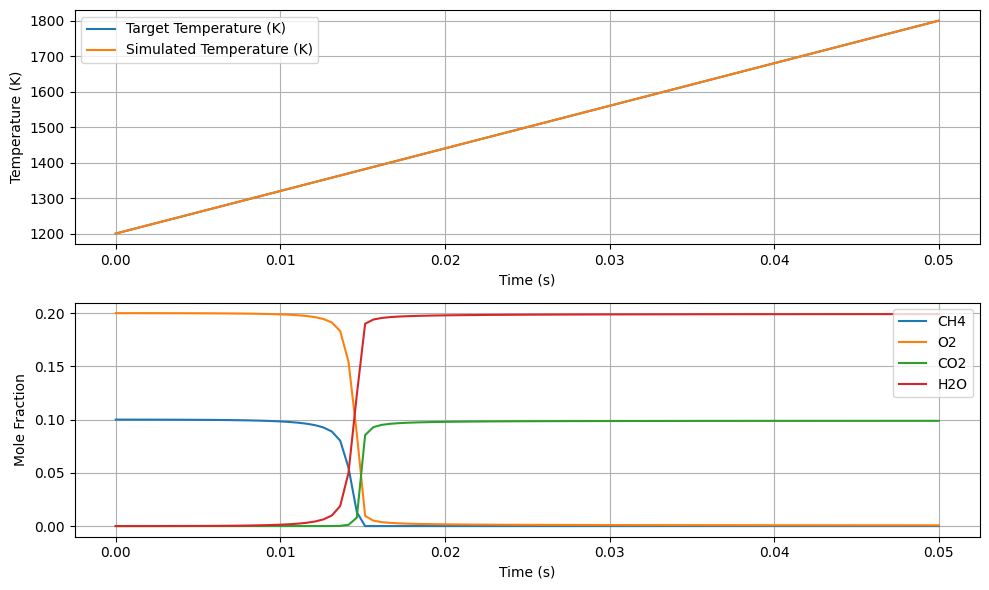

In [359]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 반응 시스템 설정: 메탄-산소 반응 시스템
gas = ct.Solution('gri30.yaml')  # GRI-Mech 3.0 반응 메커니즘 사용
gas.TPX = 1200.0, ct.one_atm, 'CH4:1, O2:2, N2:7'  # 초기 온도, 압력, 조성

# 시뮬레이션 시간 설정
time_end = 0.05  # 총 시뮬레이션 시간 (초)
n_steps = 100  # 계산 단계 수
time = np.linspace(0, time_end, n_steps)  # 시뮬레이션 시간 배열
dt = time_end / n_steps  # 시간 간격

# 사용자 정의 시간에 따른 온도 프로파일 (예: 선형 증가)
temperature_profile = np.linspace(1200, 1800, n_steps)  # 1200K에서 1800K까지 선형 증가

# 결과 저장을 위한 배열
temperature = np.zeros(n_steps)
pressure = np.zeros(n_steps)
mole_fractions = np.zeros((n_steps, len(gas.species_names)))

# 시뮬레이션 루프 (진행도 표시)
for i in tqdm(range(n_steps)):
    # 시뮬레이션 전 각 단계에서 반응기의 온도와 압력, 조성을 수동으로 설정
    gas.TPX = temperature_profile[i], gas.P, gas.X  # 온도 프로파일을 강제로 적용
    
    # 매번 새로운 reactor를 생성하여 갱신된 상태 반영
    reactor = ct.IdealGasConstPressureReactor(gas, energy='off')  # 비등온 반응기 설정
    
    # 새로운 반응기 네트워크를 생성
    sim = ct.ReactorNet([reactor])
    
    # 시뮬레이션 진행
    sim.advance(dt)  # 시간 간격만큼 진행
    
    # 결과 저장
    temperature[i] = reactor.T  # 현재 온도
    pressure[i] = reactor.thermo.P  # 현재 압력
    mole_fractions[i, :] = reactor.thermo.X  # 현재 몰분율

# 결과 플로팅
plt.figure(figsize=(10, 6))

# 온도 그래프
plt.subplot(2, 1, 1)
plt.plot(time, temperature_profile, label='Target Temperature (K)')
plt.plot(time, temperature, label='Simulated Temperature (K)')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.grid(True)
plt.legend()

# 주요 종의 몰분율 그래프 (예: CH4, O2, CO2, H2O)
plt.subplot(2, 1, 2)
plt.plot(time, mole_fractions[:, gas.species_index('CH4')], label='CH4')
plt.plot(time, mole_fractions[:, gas.species_index('O2')], label='O2')
plt.plot(time, mole_fractions[:, gas.species_index('CO2')], label='CO2')
plt.plot(time, mole_fractions[:, gas.species_index('H2O')], label='H2O')
plt.xlabel('Time (s)')
plt.ylabel('Mole Fraction')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


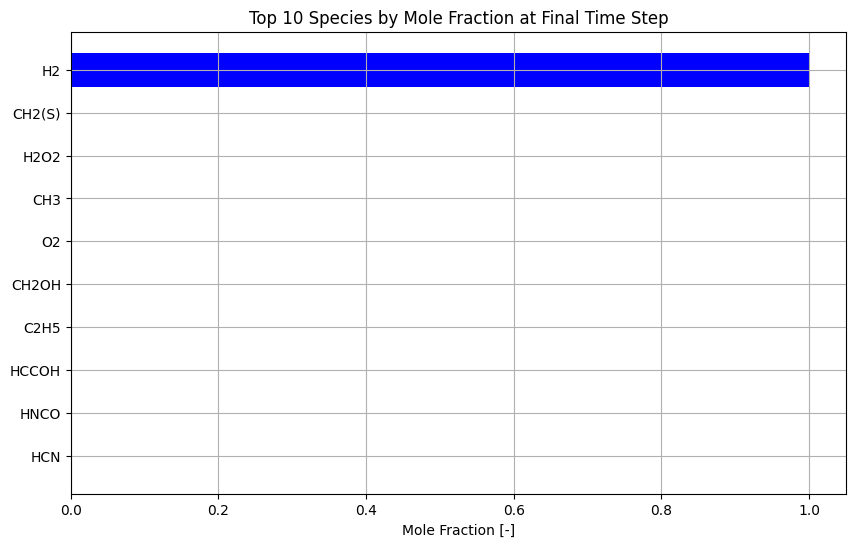

In [251]:
# 마지막 시점에서 모든 성분들의 몰 분율을 가져옵니다.
final_mole_fractions = states[-1].X

# 몰 분율이 큰 상위 10개 성분을 찾습니다.
top_10_species_indices = np.argsort(final_mole_fractions)[-10:]

# 상위 10개의 성분 이름과 그에 해당하는 몰 분율을 가져옵니다.
top_10_species_names = [gas.species_name(i) for i in top_10_species_indices]
top_10_mole_fractions = final_mole_fractions[top_10_species_indices]

# 상위 10개 성분의 몰 분율을 막대 그래프로 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(top_10_species_names, top_10_mole_fractions, color='blue')
plt.xlabel('Mole Fraction [-]')
plt.title('Top 10 Species by Mole Fraction at Final Time Step')
plt.grid(True)
plt.show()